<a href="https://colab.research.google.com/github/YousefAtefB/StanceCat-COV19/blob/main/main_TFIDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries

In [27]:
import pandas as pd
import numpy as np

import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')

import string
!pip install emoji==1.4.2
import emoji

from sklearn import svm
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import f1_score

from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Data PreProcessing

In [28]:
train = pd.read_csv('Dataset/train.csv')
text_train, category_train, stance_train = train['text'], train['category'], train['stance']

dev = pd.read_csv('Dataset/dev.csv')
text_dev, category_dev, stance_dev = dev['text'], dev['category'], dev['stance']

In [29]:
train.head(10)

,text,category,stance
0,بيل غيتس يتلقى لقاح #كوفيد19 من غير تصوير الاب...,celebrity,1
1,وزير الصحة لحد اليوم وتحديدا هلأ بمؤتمروا الصح...,info_news,1
2,قولكن رح يكونو اد المسؤولية ب لبنان لما يوصل ...,info_news,1
3,#تركيا.. وزير الصحة فخر الدين قوجة يتلقى أول ج...,celebrity,1
4,وئام وهاب يشتم الدول الخليجية في كل طلة اعلامي...,personal,0
5,"لقاح #كورونا في أميركا.. قلق متزايد من ""التوزي...",info_news,0
6,لبنان اشترى مليونان لقاح امريكي اذا شلنا يلي ع...,info_news,1
7,من عوارض لقاح كورونا<LF>هو تهكير حسابك عتويتر<...,personal,0
8,هناك 1780 مليونيراً في لبنان. ماذا لو فُرضت ال...,unrelated,0
9,دعبول حضرتك منو انت وتطلب من قائد دولة إسلامية...,info_news,1


In [30]:
dev.head(10)

,text,category,stance
0,#مريم_رجوي: <LF>حظر خامنئي المجرم شراء #لقاح_ك...,info_news,1
1,#الصحة:<LF>•تم إعطاء 259.530 جرعة من لقاح #كور...,plan,1
2,#خادم_الحرمين - حفظه الله - يتلقى الجرعة الأول...,celebrity,1
3,#الصحه_العالميه: لقاحات #كورونا آمنة ولا خوف م...,info_news,1
4,"#وزيرة_الصحة ""#هالة_زايد"" تقول إنه يجرى مراجعة...",info_news,1
5,2️⃣ وانتهى الفريق من الدراسات قبل السريرية ونش...,info_news,1
6,عاجل 🔴 <LF>.<LF><LF>.<LF><LF>وزارة الصحة :<LF>...,plan,1
7,#فيديو | السفير الأميركي لدى السعودية بعد تلقي...,info_news,1
8,تصريحات وبس الحكومة مع السيسي علي حسب اللقطة! ...,info_news,0
9,الاتحاد الاوروبي تفاوض لشراء لقاحات الكورونا م...,info_news,1


In [31]:
text_train, category_train, stance_train = np.array(train['text']), np.array(train['category']), np.array(train['stance'])
text_dev, category_dev, stance_dev = np.array(dev['text']), np.array(dev['category']), np.array(dev['stance'])

print(text_train.shape, category_train.shape, stance_train.shape)
print(text_dev.shape, category_dev.shape, stance_dev.shape)

(6988,) (6988,) (6988,)
(1000,) (1000,) (1000,)


In [32]:
# Clean/Normalize Arabic Text 
# taskeel, longation, ... etc
def clean_str(text):
    search = ["أ","إ","آ","ة","_","-","/",".","،"," و "," يا ",'"',"ـ","'","ى","\\",'\n', '\t','"','?','؟','!']
    replace = ["ا","ا","ا","ه"," "," ","","",""," و"," يا","","","","ي","",' ', ' ',' ',' ? ',' ؟ ',' ! ']
    
    #remove tashkeel
    p_tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    text = re.sub(p_tashkeel,"", text)
    
    #remove longation
    p_longation = re.compile(r'(.)\1+')
    subst = r"\1\1"
    text = re.sub(p_longation, subst, text)
    
    text = text.replace('وو', 'و')
    text = text.replace('يي', 'ي')
    text = text.replace('اا', 'ا')
    
    for i in range(0, len(search)):
        text = text.replace(search[i], replace[i])
    
    #trim    
    text = text.strip()

    return text

def PreProcessing(text, unk='<UNK>'):

  for i in range(len(text)):

    # remove links
    text[i] = re.sub(r'https?:\/\/.*[\r\n]*', '', text[i], flags=re.MULTILINE)

    # limit repeated emojis to 2
    prev_emoji = None
    cnt = 0
    remove_duplicate_emoji = []
    for c in text[i]:
        if c in emoji.UNICODE_EMOJI['en']:
            if prev_emoji == c and cnt >=2:
                continue
            if prev_emoji != c:
              cnt = 0
            prev_emoji = c
            cnt+=1
        remove_duplicate_emoji.append(c)
    text[i] = "".join(remove_duplicate_emoji)

    # seperate emojis
    text[i] = ''.join((' '+c+' ') if c in emoji.UNICODE_EMOJI['en'] else c for c in text[i])

    # Clean/Normalize Arabic Text
    text[i] = clean_str(text[i]) 

    # remove english words
    text[i] = re.sub(r'\s*[A-Za-z]+\b', '' , text[i])

    # remove numbers
    text[i] = re.sub("\d+", " ", text[i])

    # remove punctuations
    text[i] = text[i].translate(str.maketrans('', '', string.punctuation))

    # tokenize
    text[i] = nltk.tokenize.word_tokenize(text[i])

    # remove stop-words
    stopwords = set(nltk.corpus.stopwords.words("arabic"))
    text[i] = [word for word in text[i] if word not in stopwords]

    # remove emojis
    text[i] = [word for word in text[i] if word not in emoji.UNICODE_EMOJI['en']]

    # remove empty words
    text[i] = [word for word in text[i] if len(word)>2]

    # if the tweet became empty just add add <UNK> token 
    if len(text[i])==0:
      text[i] = [unk]

  return text

In [33]:
# print(max(text_train, key=len))
pre_text_train = PreProcessing(np.array(text_train))
pre_text_dev = PreProcessing(np.array(text_dev))
print(text_train[0], '\n', pre_text_train[0])
print(text_dev[0], '\n', pre_text_dev[0])
print(len(max(pre_text_train,key=len)))
# for word in text_dev[0]:
#   print(word)
for word in pre_text_train[0]:
  print(word)

بيل غيتس يتلقى لقاح #كوفيد19 من غير تصوير الابرة و لا السيرنجة و لا الدواء و لابس بولو صيفي في عز الشتاء و يقول ان إحدى مزايا عمر ال 65 عامًا هي انه مؤهل للحصول على اللقاح ... يعنى ما كان يحتاج اللقاح لو كان عمره اصغر من 65 🤔 https://t.co/QQKFFUNwBn 
 ['بيل', 'غيتس', 'يتلقي', 'لقاح', 'كوفيد', 'تصوير', 'الابره', 'السيرنجه', 'الدواء', 'ولابس', 'بولو', 'صيفي', 'الشتاء', 'ويقول', 'احدي', 'مزايا', 'عمر', 'عاما', 'انه', 'مؤهل', 'للحصول', 'علي', 'اللقاح', 'يعني', 'يحتاج', 'اللقاح', 'عمره', 'اصغر']
#مريم_رجوي: <LF>حظر خامنئي المجرم شراء #لقاح_كورونا يعد مجزرة متعمدة بحق الشعب الإيراني<LF><LF>نقل موقع مريم رجوي موقف رئيسة الجمهورية المنتخبة للمقاومة الإيرانية من تصريحات خامنئي المجرم حول حظر استيراد لقاح كورونا من الولايات المتحدة و بريطانيا و فرنسا. <LF>#اللقاح_حق_للناس https://t.co/AYXMbXjVKn 
 ['مريم', 'رجوي', 'حظر', 'خامنئي', 'المجرم', 'شراء', 'لقاح', 'كورونا', 'يعد', 'مجزره', 'متعمده', 'بحق', 'الشعب', 'الايرانينقل', 'موقع', 'مريم', 'رجوي', 'موقف', 'رئيسه', 'الجمهوريه', 'المنتخبه', 'للمقاوم

In [34]:
with open('our_processed_train.txt','w', encoding='utf8') as f:
	for i in pre_text_train:
		f.write('%s\n'%i)
print(pre_text_train[0])

['بيل', 'غيتس', 'يتلقي', 'لقاح', 'كوفيد', 'تصوير', 'الابره', 'السيرنجه', 'الدواء', 'ولابس', 'بولو', 'صيفي', 'الشتاء', 'ويقول', 'احدي', 'مزايا', 'عمر', 'عاما', 'انه', 'مؤهل', 'للحصول', 'علي', 'اللقاح', 'يعني', 'يحتاج', 'اللقاح', 'عمره', 'اصغر']


# TFIDF

In [35]:
def get_TFIDF(in_corpus):
  """
  Takes list of lists of words   
  Returns 4-tuple:
    - 2D array: list of vectors representing each word
    - 2D array: list of vectors representing each document
    - vocabulary (in the same order of first tuple returned)
    - vectorizer -> can be used for with transform() for dev/test set
  """
  corpus = [' '.join(l) for l in in_corpus]
  print('corpus size: ', len(corpus))
  vectorizer = TfidfVectorizer()
  X = vectorizer.fit_transform(corpus)
  return X.getH().toarray(), X.toarray(), vectorizer.get_feature_names_out(), vectorizer

In [36]:
def cosine_similarity(word1, word2, vocab):
  # vocab = vectorizer_TF_IDF.get_feature_names_out()
  ind1 = np.where(vocab==word1)[0].item()
  ind2 = np.where(vocab==word2)[0].item()
  return np.dot(temp_TF_IDF[ind1], temp_TF_IDF[ind2])/(np.sqrt(np.sum(temp_TF_IDF[ind1]**2))*np.sqrt(np.sum(temp_TF_IDF[ind2]**2)))

In [37]:
from sklearn.decomposition import PCA
def apply_PCA(list_of_features, n_components): # take best n_components features for all samples
  pca = PCA(n_components=n_components)
  return pca.fit_transform(list_of_features)

In [38]:
import matplotlib.pyplot as plt
def plot_annotated(points, labels=[]):
  """
  [[0 1]
  [2 3]]
  -> (0,1), (2, 3)
  """
  plt.scatter(points[:,0], points[:,1])
  for i, txt in enumerate(labels):
    plt.annotate(txt, (points[i,0], points[i,1]))
  plt.show()

corpus size:  4
[[0.         0.         0.51184851 0.        ]
 [0.46979139 0.6876236  0.         0.46979139]
 [0.58028582 0.         0.         0.58028582]
 [0.38408524 0.28108867 0.26710379 0.38408524]
 [0.         0.         0.51184851 0.        ]
 [0.         0.53864762 0.         0.        ]
 [0.38408524 0.28108867 0.26710379 0.38408524]
 [0.         0.         0.51184851 0.        ]
 [0.38408524 0.28108867 0.26710379 0.38408524]]

9 9


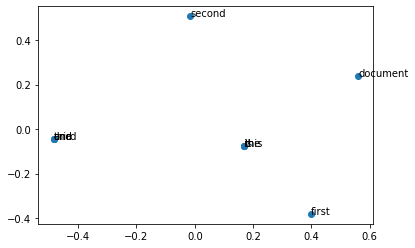

0.813894995377407
1.0
1.0


In [39]:
corpus_TF_IDF = [
    ['This','is', 'the', 'first', 'document.'],
    ['This', 'document', 'is', 'the', 'second', 'document.'],
    ['And', 'this', 'is', 'the', 'third', 'one.'],
    ['Is', 'this', 'the', 'first', 'document?'],
]
temp_TF_IDF, temp2_TF_IDF, vocab_tf_idf, vectorizer_TF_IDF = get_TFIDF(corpus_TF_IDF)
print(temp_TF_IDF)
print(vectorizer_TF_IDF.transform( [' '.join(l) for l in [['hello','world']]]))
after_pca = apply_PCA(temp_TF_IDF, 2)
print(len(temp_TF_IDF), len(after_pca))
plot_annotated(after_pca, vocab_tf_idf)
print(cosine_similarity('this', 'first', vocab_tf_idf))
print(cosine_similarity('this', 'is', vocab_tf_idf))
print(cosine_similarity('one', 'third', vocab_tf_idf))

In [40]:
word_dim = 300

In [41]:

temp_tfidf = get_TFIDF(pre_text_train)

# reduce dimensionality of each document
reduced_tfidf_train = apply_PCA(temp_tfidf[1], word_dim)

# transform dev set with the vectorizer
text_dev_for_tfidf = temp_tfidf[3].transform( [' '.join(l) for l in pre_text_dev]).toarray()

# reduce dimensionality of dev set
reduced_tfidf_dev = apply_PCA(text_dev_for_tfidf, word_dim)

corpus size:  6988


In [42]:
print(reduced_tfidf_train.shape)
print(len(text_train))

(6988, 300)
6988


In [43]:
print(stance_dev.shape)

(1000,)


# Naïve Bayes

In [44]:
def NB_TFIDF_stance():
  gnb = CategoricalNB()
  y_pred_tfidf = gnb.fit(reduced_tfidf_train, stance_train).predict(reduced_tfidf_dev)
  print("tfidf NB stance accuracy = ", np.sum(y_pred_tfidf==stance_dev)/stance_dev.size)
  f1Score_tfidf = f1_score(stance_dev, y_pred_tfidf,  average='macro')
  print("tfidf NB stance f1 score = ", f1Score_tfidf)

NB_TFIDF_stance() 

tfidf NB stance accuracy =  0.804
tfidf NB stance f1 score =  0.29711751662971175


In [45]:
def NB_TFIDF_category():
  gnb = CategoricalNB()
  y_pred_tfidf = gnb.fit(reduced_tfidf_train, category_train).predict(reduced_tfidf_dev)
  print("tfidf NB categories accuracy = ", np.sum(y_pred_tfidf==category_dev)/category_dev.size)
  f1Score_tfidf = f1_score(category_dev, y_pred_tfidf, average='macro')
  print("tfidf NB categories f1 score = ", f1Score_tfidf)

NB_TFIDF_category()

tfidf NB categories accuracy =  0.545
tfidf NB categories f1 score =  0.07055016181229774


# SVM

In [46]:
def SVM_TFIDF_stance():
  clf = svm.SVC()
  clf.fit(reduced_tfidf_train, stance_train)
  y_pred_tfidf = clf.predict(reduced_tfidf_dev)
  print("tfidf SVM stance accuracy = ", np.sum(y_pred_tfidf==stance_dev)/stance_dev.size)
  f1Score_tfidf = f1_score(stance_dev, y_pred_tfidf, average='macro')
  print("tfidf SVM stance f1 score = ", f1Score_tfidf)

SVM_TFIDF_stance()

tfidf SVM stance accuracy =  0.804
tfidf SVM stance f1 score =  0.29711751662971175


In [47]:
def SVM_TFIDF_category():
  clf = svm.SVC()
  clf.fit(reduced_tfidf_train, category_train)
  y_pred_tfidf = clf.predict(reduced_tfidf_dev)
  print("tfidf SVM categories accuracy = ", np.sum(y_pred_tfidf==category_dev)/category_dev.size)
  f1Score_tfidf = f1_score(category_dev, y_pred_tfidf, average='macro')
  print("tfidf SVM categories f1 score = ", f1Score_tfidf)

SVM_TFIDF_category()

tfidf SVM categories accuracy =  0.593
tfidf SVM categories f1 score =  0.12742390033003945
